In [2]:
import sys
sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt
import itertools
import scipy as sp

from utils_reconstruction import image_similarity as imsim
import tifffile

In [3]:

## load reconstruction .npy files
num_neurons = [7863, 7908, 8202, 7939, 8122]
mouse_names = [
    "dynamic29515-10-12-Video-9b4f6a1a067fe51e15306b9628efea20",
    "dynamic29623-4-9-Video-9b4f6a1a067fe51e15306b9628efea20",
    "dynamic29647-19-8-Video-9b4f6a1a067fe51e15306b9628efea20",
    "dynamic29712-5-9-Video-9b4f6a1a067fe51e15306b9628efea20",
    "dynamic29755-2-8-Video-9b4f6a1a067fe51e15306b9628efea20",
]

max_num_neurons = np.max(num_neurons)
model_list = np.array([0,1,2,3,4,5,6]) # 1,2,3,4,5,6 # 
mice = range(0,5)
trials = range(0,10)
trial_names = np.array([[0,1,2,10,4,5,6,7,8,11],
                        [10,1,2,3,11,5,6,7,8,9],
                        [10,1,14,3,4,5,6,15,16,9],
                        [0,1,2,3,10,5,6,7,8,9],
                        [0,1,2,3,4,5,6,7,8,9]]) # after replacing hashing error videos
eval_frame_skip = 30 # default 30
mask_th = 1

video_gt=np.nan*np.ones((len(mice),len(trials),300,36,64))
behavior=np.nan*np.ones((len(mice),len(trials),2,300))
pupil_center=np.nan*np.ones((len(mice),len(trials),2,300))
responses=np.nan*np.ones((len(mice),len(trials),max_num_neurons,300))
responses_pred_gt=np.nan*np.ones((model_list.size,len(mice),len(trials),max_num_neurons,300,1)) # prediction is based on current model not ensemble
mask=np.nan*np.ones((len(mice),36,64))

video_pred=np.nan*np.ones((model_list.size,len(mice),len(trials),300,36,64))
responses_pred_recon=np.nan*np.ones((model_list.size,len(mice),len(trials),max_num_neurons,300))

video_pred_from_pred_resp=np.nan*np.ones((model_list.size,len(mice),len(trials),300,36,64))
responses_pred_recon_from_pred_resp=np.nan*np.ones((model_list.size,len(mice),len(trials),max_num_neurons,300))

video_pred_notrainmask=np.nan*np.ones((model_list.size,len(mice),len(trials),300,36,64))
responses_pred_recon_notrainmask=np.nan*np.ones((model_list.size,len(mice),len(trials),max_num_neurons,300))

video_pred_stricttrainmask=np.nan*np.ones((model_list.size,len(mice),len(trials),300,36,64))
responses_pred_recon_stricttrainmask=np.nan*np.ones((model_list.size,len(mice),len(trials),max_num_neurons,300))

video_pred_ensembleGrad=np.nan*np.ones((len(mice),len(trials),300,36,64))
responses_pred_recon_ensembleGrad=np.nan*np.ones((len(mice),len(trials),max_num_neurons,300))


for model_n in model_list:
    for mouse in mice:
        for trial in trials:
            datapath=f'../reconstructions/modelfold[{model_n}]_datafold_0_pop100_hpc_round5/reconstruction_summary_m{mouse}_t{trial_names[mouse,trial]}.npy'
            print(datapath)
            data = np.load(datapath, allow_pickle=True).item()
            if model_n==model_list[1]:
                video_gt[mouse,trial] = data['video_gt']
                behavior[mouse,trial] = data['behavior']
                pupil_center[mouse,trial] = data['pupil_center']
                responses[mouse,trial,0:num_neurons[mouse],:] = data['responses'].cpu().numpy()
            
            responses_pred_gt[model_n,mouse,trial,0:num_neurons[mouse],:,:] = data['responses_predicted_gt'].copy()
            mask[mouse] = data['mask'][14:14+36,:]
            
            # from ground truth activity
            video_pred[model_n,mouse,trial] = data['video_pred']
            responses_pred_recon[model_n,mouse,trial,0:num_neurons[mouse],:] = data['responses_predicted_full']
            
            # from predicted activity
            datapath=f'../reconstructions/modelfold[{model_n}]_datafold_0_pop100_hpc_round7_fit_to_predicted/reconstruction_summary_m{mouse}_t{trial_names[mouse,trial]}.npy'
            data = np.load(datapath, allow_pickle=True).item()
            video_pred_from_pred_resp[model_n,mouse,trial] = data['video_pred']
            responses_pred_recon_from_pred_resp[model_n,mouse,trial,0:num_neurons[mouse],:] = data['responses_predicted_full']
            
            # no training mask
            datapath=f'../reconstructions/modelfold[{model_n}]_datafold_0_pop100_hpc_round9_nontrainmask/reconstruction_summary_m{mouse}_t{trial_names[mouse,trial]}.npy'
            data = np.load(datapath, allow_pickle=True).item()
            video_pred_notrainmask[model_n,mouse,trial] = data['video_pred']
            responses_pred_recon_notrainmask[model_n,mouse,trial,0:num_neurons[mouse],:] = data['responses_predicted_full']
            
            # strict training mask
            datapath=f'../reconstructions/modelfold[{model_n}]_datafold_0_pop100_hpc_round10_strictmask/reconstruction_summary_m{mouse}_t{trial_names[mouse,trial]}.npy'
            data = np.load(datapath, allow_pickle=True).item()
            video_pred_stricttrainmask[model_n,mouse,trial] = data['video_pred']
            responses_pred_recon_stricttrainmask[model_n,mouse,trial,0:num_neurons[mouse],:] = data['responses_predicted_full']
            
            if model_n==model_list[0]:
                # with ensembled gradients
                datapath=f'../reconstructions/modelfold[0 1 2 3 4 5 6]_datafold_0_pop100_hpc_round8/reconstruction_summary_m{mouse}_t{trial_names[mouse,trial]}.npy'
                data = np.load(datapath, allow_pickle=True).item()
                video_pred_ensembleGrad[mouse,trial] = data['video_pred']
                responses_pred_recon_ensembleGrad[mouse,trial,0:num_neurons[mouse],:] = data['responses_predicted_full']
            

# remove eval grace period
video_gt = video_gt[:,:,eval_frame_skip:,:,:]
behavior = behavior[:,:,:,eval_frame_skip:]
pupil_center = pupil_center[:,:,:,eval_frame_skip:]
responses = responses[:,:,:,eval_frame_skip:]
responses_pred_gt = responses_pred_gt[:,:,:,:,eval_frame_skip:]
video_pred = video_pred[:,:,:,eval_frame_skip:,:,:]
responses_pred_recon = responses_pred_recon[:,:,:,:,eval_frame_skip:]

video_pred_notrainmask = video_pred_notrainmask[:,:,:,eval_frame_skip:,:,:]
responses_pred_recon_notrainmask = responses_pred_recon_notrainmask[:,:,:,:,eval_frame_skip:]

video_pred_stricttrainmask = video_pred_stricttrainmask[:,:,:,eval_frame_skip:,:,:]
responses_pred_recon_stricttrainmask = responses_pred_recon_stricttrainmask[:,:,:,:,eval_frame_skip:]

video_pred_from_pred_resp = video_pred_from_pred_resp[:,:,:,eval_frame_skip:,:,:]
responses_pred_recon_from_pred_resp = responses_pred_recon_from_pred_resp[:,:,:,:,eval_frame_skip:]

video_pred_ensembleGrad = video_pred_ensembleGrad[:,:,eval_frame_skip:,:,:]
responses_pred_recon_ensembleGrad = responses_pred_recon_ensembleGrad[:,:,:,eval_frame_skip:]

print('video_gt: ', video_gt.shape, video_gt.min(), video_gt.max())     
print('behavior: ', behavior.shape, behavior.min(), behavior.max())
print('pupil_center: ', pupil_center.shape , pupil_center.min(), pupil_center.max())
print('responses: ', responses.shape, responses.min(), responses.max())
print('responses_pred_gt: ', responses_pred_gt.shape, responses_pred_gt.min(), responses_pred_gt.max())
print('video_pred: ', video_pred.shape, video_pred.min(), video_pred.max())
print('mask: ', mask.shape, mask.min(), mask.max())
print('responses_pred_recon: ', responses_pred_recon.shape, responses_pred_recon.min(), responses_pred_recon.max())

video_pred = np.clip(video_pred, 0, 255)
video_pred_from_pred_resp = np.clip(video_pred_from_pred_resp, 0, 255)
video_pred_notrainmask = np.clip(video_pred_notrainmask, 0, 255)
video_pred_stricttrainmask = np.clip(video_pred_stricttrainmask, 0, 255)
video_pred_ensembleGrad = np.clip(video_pred_ensembleGrad, 0, 255)


../reconstructions/modelfold[0]_datafold_0_pop100_hpc_round5/reconstruction_summary_m0_t0.npy
../reconstructions/modelfold[0]_datafold_0_pop100_hpc_round5/reconstruction_summary_m0_t1.npy
../reconstructions/modelfold[0]_datafold_0_pop100_hpc_round5/reconstruction_summary_m0_t2.npy
../reconstructions/modelfold[0]_datafold_0_pop100_hpc_round5/reconstruction_summary_m0_t10.npy
../reconstructions/modelfold[0]_datafold_0_pop100_hpc_round5/reconstruction_summary_m0_t4.npy
../reconstructions/modelfold[0]_datafold_0_pop100_hpc_round5/reconstruction_summary_m0_t5.npy
../reconstructions/modelfold[0]_datafold_0_pop100_hpc_round5/reconstruction_summary_m0_t6.npy
../reconstructions/modelfold[0]_datafold_0_pop100_hpc_round5/reconstruction_summary_m0_t7.npy
../reconstructions/modelfold[0]_datafold_0_pop100_hpc_round5/reconstruction_summary_m0_t8.npy
../reconstructions/modelfold[0]_datafold_0_pop100_hpc_round5/reconstruction_summary_m0_t11.npy
../reconstructions/modelfold[0]_datafold_0_pop100_hpc_roun

In [4]:
# quick estmiate of corr (not used in paper)
print('corr gt vid with pred vid', np.corrcoef(video_gt.reshape(-1),video_pred.mean(axis=0).reshape(-1))[0,1])
print('corr gt vid with pred vid from pred activity', np.corrcoef(video_gt.reshape(-1),video_pred_from_pred_resp.mean(axis=0).reshape(-1))[0,1])
print('corr pred vid with pred vid from pred activity', np.corrcoef(video_pred.mean(axis=0).reshape(-1),video_pred_from_pred_resp.mean(axis=0).reshape(-1))[0,1])

corr gt vid with pred vid 0.21096284885321717
corr gt vid with pred vid from pred activity 0.31410846961326194
corr pred vid with pred vid from pred activity 0.6361848602402105


In [5]:
# ensemble and combine trials and mice
true_resp = responses.reshape((len(mice)*len(trials),max_num_neurons,300-eval_frame_skip))
pred_resp = responses_pred_gt.mean(axis=(0)).reshape((len(mice)*len(trials),max_num_neurons,300-eval_frame_skip))
recon_resp = responses_pred_recon.mean(axis=(0)).reshape((len(mice)*len(trials),max_num_neurons,300-eval_frame_skip))
recon_from_pred_resp = responses_pred_recon_from_pred_resp.mean(axis=(0)).reshape((len(mice)*len(trials),max_num_neurons,300-eval_frame_skip))

# vectorize in time and neurons
true_resp = np.moveaxis(true_resp,0,-1).reshape((max_num_neurons*(300-eval_frame_skip),len(mice)*len(trials))).T
pred_resp = np.moveaxis(pred_resp,0,-1).reshape((max_num_neurons*(300-eval_frame_skip),len(mice)*len(trials))).T
recon_resp = np.moveaxis(recon_resp,0,-1).reshape((max_num_neurons*(300-eval_frame_skip),len(mice)*len(trials))).T
recon_from_pred_resp = np.moveaxis(recon_from_pred_resp,0,-1).reshape((max_num_neurons*(300-eval_frame_skip),len(mice)*len(trials))).T

# correlate true_resp to pred_resp and recon_resp
corr_pred = np.zeros((len(mice)*len(trials)))
corr_recon = np.zeros((len(mice)*len(trials)))
corr_recon_from_pred_resp_toGT = np.zeros((len(mice)*len(trials)))
corr_recon_from_pred_resp_toPred = np.zeros((len(mice)*len(trials)))

for i in range(len(mice)*len(trials)):
    corr_pred[i] = np.corrcoef(true_resp[i],pred_resp[i])[0,1]
    corr_recon[i] = np.corrcoef(true_resp[i],recon_resp[i])[0,1]
    corr_recon_from_pred_resp_toGT[i] = np.corrcoef(true_resp[i],recon_from_pred_resp[i])[0,1]
    corr_recon_from_pred_resp_toPred[i] = np.corrcoef(pred_resp[i],recon_from_pred_resp[i])[0,1]
    
print('corr_pred mean: ', np.nanmean(corr_pred), 'std: ', np.nanstd(corr_pred))
print('corr_recon mean: ', np.nanmean(corr_recon), 'std: ', np.nanstd(corr_recon))
print('corr_recon_from_pred_resp_toGT mean: ', np.nanmean(corr_recon_from_pred_resp_toGT), 'std: ', np.nanstd(corr_recon_from_pred_resp_toGT))
print('corr_recon_from_pred_resp_toPred mean: ', np.nanmean(corr_recon_from_pred_resp_toPred), 'std: ', np.nanstd(corr_recon_from_pred_resp_toPred))

corr_pred mean:  0.37935230851616436 std:  0.04194194971060125
corr_recon mean:  0.44211981514944815 std:  0.0326864062252184
corr_recon_from_pred_resp_toGT mean:  0.31630166313067776 std:  0.05526912029430007
corr_recon_from_pred_resp_toPred mean:  0.8174422345906566 std:  0.08102809146945796


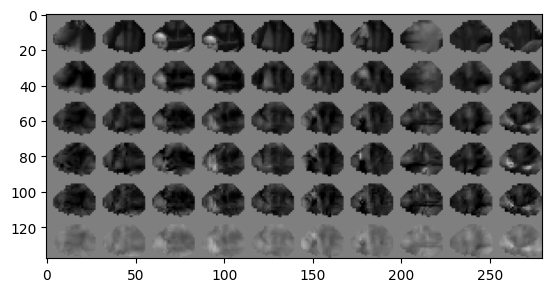

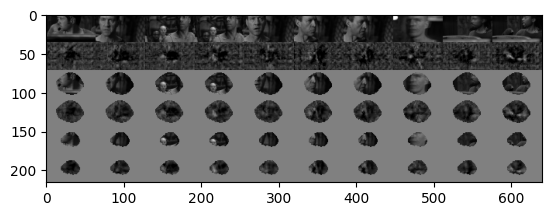

In [6]:
# contrast adjust images
# for each movie, take the mean image across all time points, then calculate the mean and std of that image
# normalize the predicted images by subtracting the mean and dividing by the std
mouse_n,trial_n,frame_n, h_n, w_n = video_gt.shape[0],video_gt.shape[1],video_gt.shape[2],video_gt.shape[3],video_gt.shape[4]

# arithmetic mean of all models
def gaussian_filter_video(video):
    video_filtered = np.zeros(video.shape)
    for mouse in range(video.shape[0]):
        for trial in range(video.shape[1]):        
            video_filtered[mouse,trial] = sp.ndimage.gaussian_filter(video[mouse,trial], sigma=(0.5, 0.5, 0.5))
    return video_filtered

def norm_video(video_in,video_target,mask,mask_th, only_lum = False):
    mouse_n,trial_n,frame_n, h_n, w_n = video_target.shape[0],video_target.shape[1],video_target.shape[2],video_target.shape[3],video_target.shape[4]
    
    # get target mean and std
    video_target_frame_mean = np.nanmean(video_target, axis=-3)
    video_target_frame_mean = video_target_frame_mean * np.where(np.expand_dims(mask,axis=1).repeat(trial_n,axis=1) >= mask_th,1,np.nan) 
    target_means = np.nanmean(video_target_frame_mean, axis=(-1,-2))
    target_stds = np.nanstd(video_target_frame_mean, axis=(-1,-2))
    
    # get start mean and std
    video_in_frame_mean = np.nanmean(video_in, axis=-3)
    video_in_frame_mean = video_in_frame_mean * np.where(np.expand_dims(mask,axis=1).repeat(trial_n,axis=1) >= mask_th,1,np.nan) 
    start_means = np.nanmean(video_in_frame_mean, axis=(-1,-2))
    start_stds = np.nanstd(video_in_frame_mean, axis=(-1,-2))
    
    if only_lum:
        target_stds = start_stds
    
    # expand dims of mean and std in time h and w
    target_means = np.expand_dims(target_means,axis=(2,3,4)).repeat(frame_n,axis=-3).repeat(h_n,axis=-2).repeat(w_n,axis=-1)
    target_stds = np.expand_dims(target_stds,axis=(2,3,4)).repeat(frame_n,axis=-3).repeat(h_n,axis=-2).repeat(w_n,axis=-1)
    start_means = np.expand_dims(start_means,axis=(2,3,4)).repeat(frame_n,axis=-3).repeat(h_n,axis=-2).repeat(w_n,axis=-1)
    start_stds = np.expand_dims(start_stds,axis=(2,3,4)).repeat(frame_n,axis=-3).repeat(h_n,axis=-2).repeat(w_n,axis=-1)

    # normalize video
    video_in_zscore = (video_in - start_means)  / start_stds
    video_in_norm = (video_in_zscore*target_stds) + target_means
    video_in_norm = np.clip(video_in_norm, 0, 255)
    
    # reaply mask
    video_in_norm_masked = apply_mask(video_in_norm,mask,mask_th)

    return video_in_norm_masked

def apply_mask(video_in,mask,mask_th,outpaint_value=255/2):
    mouse_n,trial_n,frame_n, h_n, w_n = video_gt.shape[0],video_gt.shape[1],video_gt.shape[2],video_gt.shape[3],video_gt.shape[4]
    mask_expanded = np.expand_dims(mask,axis=(1,2)).repeat(trial_n,axis=1).repeat(frame_n,axis=2)
    video_in_masked = video_in * np.where(mask_expanded >= mask_th,1,np.nan)
    video_in_masked[np.isnan(video_in_masked)] = outpaint_value
    return video_in_masked

def concatenate_videos(video_all_versions):
    dims = video_all_versions.shape
    n_versions=dims[0]
    mouse_n=dims[1]
    trial_n=dims[2]
    frame_n=dims[3]
    h=dims[4]
    w=dims[5]
    
    # tile videos based on gt vs pred (dim 0) as rows and trial as columns
    video_all_versions = np.moveaxis(np.moveaxis(video_all_versions,-2,1).reshape((n_versions*h,mouse_n,trial_n,frame_n,w)),0,-2)
    video_all_versions_hyperstack=np.transpose(video_all_versions.copy(),(2,1,0,3,4))

    # tiled videos
    video_all_versions = np.moveaxis(np.moveaxis(video_all_versions,(1,-1),(0,1)).reshape((trial_n*w,mouse_n,frame_n,h*n_versions)),0,-1) # tile mice in hight
    video_all_versions_tiled = np.moveaxis(np.moveaxis(video_all_versions,-2,1).reshape((n_versions*h*mouse_n,frame_n,w*trial_n)),0,-2) # tile trials and width
    plt.imshow(video_all_versions_tiled[100,:,:],cmap='gray',vmin=0,vmax=255)

    # time series of video # 1 frame per second
    choose_frames = np.concatenate((np.arange(0,video_all_versions_hyperstack.shape[0],30).astype(int),[video_all_versions_hyperstack.shape[0]-1]))
    number_of_frames = choose_frames.shape[0]

    video_all_versions_ = video_all_versions_hyperstack[choose_frames,:,:,:,:].copy()
    video_all_versions__timeseries = np.moveaxis(np.moveaxis(video_all_versions_,(-1),(1)).reshape((w*number_of_frames,mouse_n,trial_n,h*n_versions)),0,-1)# tile time in width
    video_all_versions_timeseries = video_all_versions__timeseries.reshape((mouse_n*trial_n,h*n_versions,w*number_of_frames))# tile time in width
    
    return video_all_versions_hyperstack, video_all_versions_tiled, video_all_versions_timeseries


video_gt_masked = apply_mask(video_gt,mask,mask_th)
video_recon_from_pred = norm_video(gaussian_filter_video(np.nanmean(video_pred_from_pred_resp, axis=0)),video_gt,mask,1)
video_recon_masked = norm_video(gaussian_filter_video(np.nanmean(video_pred, axis=0)),video_gt,mask,1)
video_recon_nonNorm = apply_mask(gaussian_filter_video(np.nanmean(video_pred, axis=0)),mask,1)
video_recon_masked_notsmoothed = norm_video(np.nanmean(video_pred, axis=0),video_gt,mask,1)
video_recon_ensembleGrad_norm = norm_video(gaussian_filter_video(video_pred_ensembleGrad),video_gt,mask,1)

# # crop to masks size
mask_all = np.where(np.sum(np.where(mask >= 1,1,0),axis=0) >= 1,1,0)
mask_all_idx = np.where(mask_all == 1)
h_min, h_max = np.min(mask_all_idx[0]), np.max(mask_all_idx[0])
w_min, w_max = np.min(mask_all_idx[1]), np.max(mask_all_idx[1])
h = h_max - h_min
w = w_max - w_min

video_gt_cropped=video_gt[:,:,:,h_min:h_max,w_min:w_max]
video_gt_masked_cropped=video_gt_masked[:,:,:,h_min:h_max,w_min:w_max]
video_recon_from_pred_cropped=video_recon_from_pred[:,:,:,h_min:h_max,w_min:w_max]
video_recon_masked_cropped=video_recon_masked[:,:,:,h_min:h_max,w_min:w_max]
video_recon_nonNorm_cropped=video_recon_nonNorm[:,:,:,h_min:h_max,w_min:w_max]
video_recon_masked_notsmoothed_cropped=video_recon_masked_notsmoothed[:,:,:,h_min:h_max,w_min:w_max]
video_recon_ensembleGrad_cropped=video_recon_ensembleGrad_norm[:,:,:,h_min:h_max,w_min:w_max]

# concatenate versions
video_all_versions = np.concatenate((np.expand_dims(video_gt_masked_cropped,axis=0),
                                         np.expand_dims(video_recon_from_pred_cropped,axis=0),
                                         np.expand_dims(video_recon_masked_cropped,axis=0),
                                         np.expand_dims(video_recon_ensembleGrad_cropped,axis=0),
                                         np.expand_dims(video_recon_masked_notsmoothed_cropped,axis=0),
                                         np.expand_dims(video_recon_nonNorm_cropped,axis=0),
                                        ),axis=0) 

video_all_versions_hyperstack, video_all_versions_tiled, video_all_versions_timeseries = concatenate_videos(video_all_versions)

plt.imshow(video_all_versions_timeseries[0,:],cmap='gray',vmin=0,vmax=255) 
plt.show()

# save video as tiff
tifffile.imwrite('../reconstructions/all_processed_videos_tiled_allversions.tiff', 
                video_all_versions_tiled.astype('uint8'),
                imagej=True,
                metadata = {'unit': 'um','fps': 30.0,'axes': 'TYX',})
# save video as tiff
tifffile.imwrite('../reconstructions/all_processed_videos_hyperstack_allversions.tiff', 
                video_all_versions_hyperstack.astype('uint16'),
                imagej=True,
                metadata = {'unit': 'um','fps': 30.0,'axes': 'TZCYX',})
# save video as tiff
tifffile.imwrite('../reconstructions/all_processed_videos_time_series_allversions.tiff', 
                video_all_versions_timeseries.astype('uint16'),
                imagej=True,
                metadata = {'unit': 'um','fps': 30.0,'axes': 'ZYX',})

## different masking versions
video_gt_noMask = video_gt
video_gt_trainMask = apply_mask(video_gt,mask,0.5)
video_gt_masked = apply_mask(video_gt,mask,1)
video_recon_masked = norm_video(gaussian_filter_video(np.nanmean(video_pred, axis=0)),video_gt,mask,1)
video_recon_trainMask = norm_video(gaussian_filter_video(np.nanmean(video_pred, axis=0)),video_gt,mask,0.5)
video_recon_noTrainMask = norm_video(gaussian_filter_video(np.nanmean(video_pred_notrainmask, axis=0)),video_gt,mask,-1)
video_recon_StrictTrainMask = norm_video(gaussian_filter_video(np.nanmean(video_pred_stricttrainmask, axis=0)),video_gt,mask,1)

video_all_mask_versions = np.concatenate((np.expand_dims(video_gt_noMask,axis=0),
                                         np.expand_dims(video_recon_noTrainMask,axis=0),
                                         np.expand_dims(video_gt_trainMask,axis=0),
                                         np.expand_dims(video_recon_trainMask,axis=0),
                                         np.expand_dims(video_gt_masked,axis=0),
                                         np.expand_dims(video_recon_StrictTrainMask,axis=0)
                                        ),axis=0) 

_, video_all_mask_versions_tiled, video_all_mask_versions_timeseries = concatenate_videos(video_all_mask_versions)

plt.imshow(video_all_mask_versions_timeseries[0,:],cmap='gray',vmin=0,vmax=255) 
plt.show()

# save video as tiff
tifffile.imwrite('../reconstructions/all_processed_videos_tiled_allmasks.tiff', 
                video_all_mask_versions_tiled.astype('uint8'),
                imagej=True,
                metadata = {'unit': 'um','fps': 30.0,'axes': 'TYX',})

# save video as tiff
tifffile.imwrite('../reconstructions/all_processed_videos_time_series_allmasks.tiff', 
                video_all_mask_versions_timeseries.astype('uint16'),
                imagej=True,
                metadata = {'unit': 'um','fps': 30.0,'axes': 'ZYX',})

# create error maps
error_threshold = 0
video_recon_from_pred_nonNorm_cropped = apply_mask(gaussian_filter_video(np.nanmean(video_pred_from_pred_resp, axis=0)),mask,1)[:,:,:,h_min:h_max,w_min:w_max]
video_recon_nonNorm_cropped = apply_mask(gaussian_filter_video(np.nanmean(video_pred, axis=0)),mask,1)[:,:,:,h_min:h_max,w_min:w_max]

video_error = video_recon_nonNorm_cropped-video_recon_from_pred_nonNorm_cropped
video_error_positive = np.where(video_error > 0, video_error, 0) 
video_error_negative = np.where(video_error < 0, video_error, 0)*-1
video_error_positive = np.where(video_error_positive>error_threshold,video_error_positive,0)
video_error_negative = np.where(video_error_negative>error_threshold,video_error_negative,0)
video_error_positive = apply_mask(video_error_positive,mask[:,h_min:h_max,w_min:w_max],mask_th,outpaint_value=0) # apply mask
video_error_negative = apply_mask(video_error_negative,mask[:,h_min:h_max,w_min:w_max],mask_th,outpaint_value=0)

# tiled videos
video_referencea = np.moveaxis(np.moveaxis(video_gt_cropped,(1,-1),(0,1)).reshape((trial_n*w,mouse_n,frame_n,h)),0,-1) # tile mice in hight
video_referencea = np.moveaxis(np.moveaxis(video_referencea,-2,1).reshape((h*mouse_n,frame_n,w*trial_n)),0,-2) # tile trials and width
video_referenceb = np.moveaxis(np.moveaxis(video_recon_nonNorm_cropped,(1,-1),(0,1)).reshape((trial_n*w,mouse_n,frame_n,h)),0,-1) # tile mice in hight
video_referenceb = np.moveaxis(np.moveaxis(video_referenceb,-2,1).reshape((h*mouse_n,frame_n,w*trial_n)),0,-2) # tile trials and width
video_referencec = np.moveaxis(np.moveaxis(video_recon_from_pred_nonNorm_cropped,(1,-1),(0,1)).reshape((trial_n*w,mouse_n,frame_n,h)),0,-1) # tile mice in hight
video_referencec = np.moveaxis(np.moveaxis(video_referencec,-2,1).reshape((h*mouse_n,frame_n,w*trial_n)),0,-2) # tile trials and width
video_error_positive = np.moveaxis(np.moveaxis(video_error_positive,(1,-1),(0,1)).reshape((trial_n*w,mouse_n,frame_n,h)),0,-1) # tile mice in hight
video_error_positive = np.moveaxis(np.moveaxis(video_error_positive,-2,1).reshape((h*mouse_n,frame_n,w*trial_n)),0,-2) # tile trials and width
video_error_negative = np.moveaxis(np.moveaxis(video_error_negative,(1,-1),(0,1)).reshape((trial_n*w,mouse_n,frame_n,h)),0,-1) # tile mice in hight
video_error_negative = np.moveaxis(np.moveaxis(video_error_negative,-2,1).reshape((h*mouse_n,frame_n,w*trial_n)),0,-2) # tile trials and width

video_errormaps = np.concatenate((video_referencea[None],video_referenceb[None],video_referencec[None],video_error_positive[None], video_error_negative[None]), axis=0)

# save video as tiff
tifffile.imwrite('../reconstructions/video_errormaps.tiff', 
                np.moveaxis(video_errormaps,0,1).astype('uint16'),
                imagej=True,
                metadata = {'unit': 'um','fps': 30.0,'axes': 'TCYX',})

/tmp/ipykernel_1597428/887019548.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  reinotopic_area_map[i,j] = calc_pix_area(i,j)


recon vs from predicted:  0.5687160439598533  vs  0.7663389724135738
Pairwise t-tests:  1.535503548145431e-05
recon vs grad ensembling:  0.5687160439598533  vs  0.551678889767367
Pairwise t-tests:  0.01984676278147517
recon vs grad ensembling:  0.5687160439598533  vs  0.532975492920991
Pairwise t-tests:  6.257442758484064e-06
performance at eval alpha=1: (red) 0.5102209340430924 , (blue) 0.5510978055959657 , (black) 0.5687160439598533


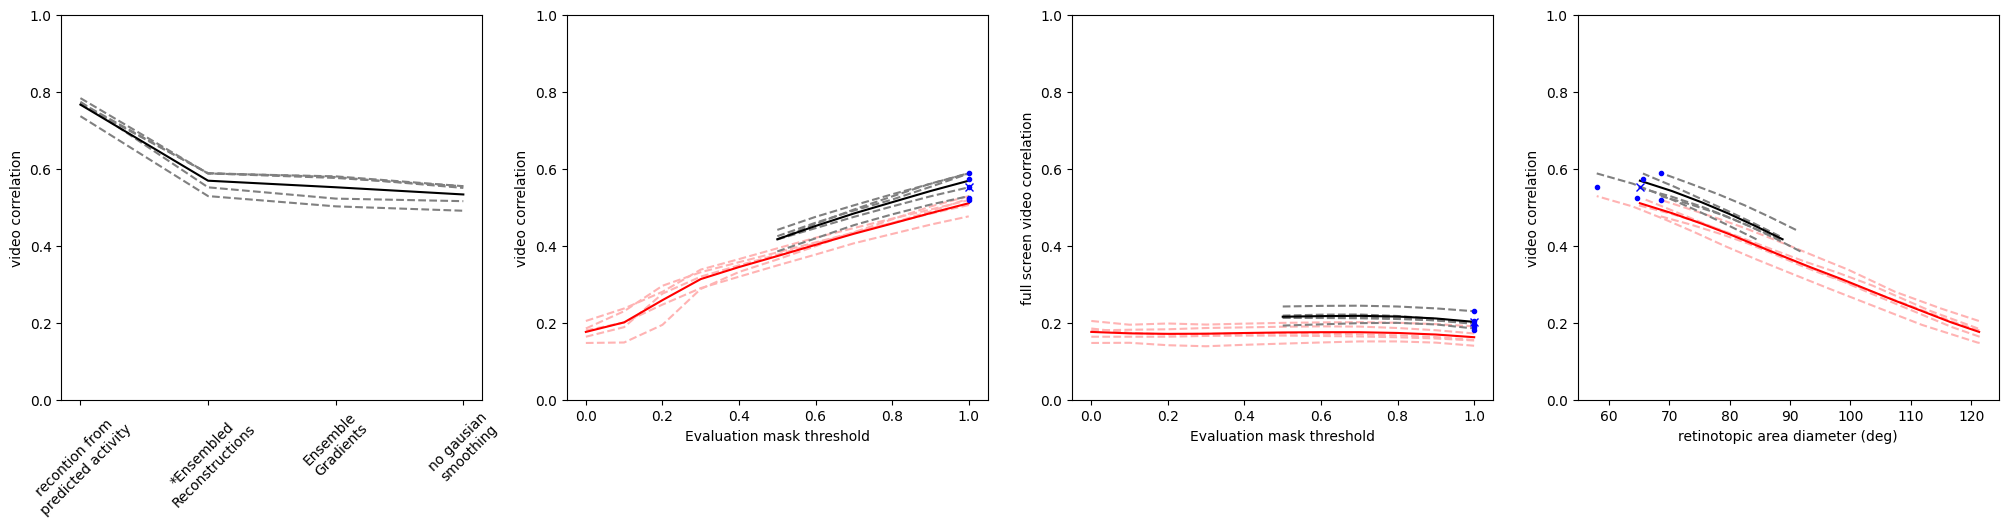

In [7]:
# eccentricity map
monitor_hight_cm = 31.8
monitor_width_cm = 56.5
monitor_distance_cm = 15
h_pix = 36
w_pix = 64
pix_size_cm = monitor_width_cm / w_pix # pixel size in cm

def calc_pix_area(h,w):
        pix_center_h = (h-(h_pix/2-0.5))
        pix_h_range = np.sort(np.abs((pix_center_h-0.5, pix_center_h+0.5)))*pix_size_cm
        pix_center_w = (w-(w_pix/2-0.5))
        pix_w_range = np.sort(np.abs((pix_center_w-0.5, pix_center_w+0.5)))*pix_size_cm

        pix_h_cm = np.abs(np.diff(pix_h_range))
        pix_w_cm = np.abs(np.diff(pix_w_range))
        pix_h_deg = np.abs(np.diff(np.rad2deg(np.arctan((pix_h_range/monitor_distance_cm)))))   
        pix_w_deg = np.abs(np.diff(np.rad2deg(np.arctan((pix_w_range/monitor_distance_cm)))))

        pix_area_deg = pix_h_deg * pix_w_deg

        return pix_area_deg

reinotopic_area_map = np.zeros((36,64))
for i in range(36):
    for j in range(64):
        reinotopic_area_map[i,j] = calc_pix_area(i,j)
        
def calc_area_diameter(mask,mask_th):
        reinotopic_area_map_masked = np.where(mask >= mask_th,1,0)*reinotopic_area_map
        return np.sqrt(reinotopic_area_map_masked.sum()/np.pi)*2

def calc_vid_corr(video_gt,video_pred,mask,mask_th):
        # distribution of correlation values for full model
        video_corr = np.zeros((len(mice),len(trials)))
        for mouse in mice:
                for trial in trials:
                        vid_corr_values=imsim.reconstruction_video_corr(video_gt[mouse,trial],
                                video_pred[mouse,trial],
                                np.where(mask[mouse] >= mask_th,1,0))

                        video_corr[mouse,trial] = vid_corr_values

        return video_corr

def calc_full_screen_vid_corr(video_gt,video_pred,mask,mask_th):
        # here we first apply the mask to the reoncstructed video but not to the ground truth video and then evaluate the correlation across all pixels not just those within the mask
        video_pred_masked = apply_mask(video_pred,mask,mask_th)

        # distribution of correlation values for full model
        video_corr = np.zeros((len(mice),len(trials)))
        for mouse in mice:
                for trial in trials:
                        vid_corr_values=imsim.reconstruction_video_corr(video_gt[mouse,trial],
                                video_pred_masked[mouse,trial],
                                np.where(mask[mouse] >= 0,1,0))

                        video_corr[mouse,trial] = vid_corr_values

        return video_corr

# no need to actually apply mask because that is done in calc_avg_frame_corr
video_recon_from_pred = gaussian_filter_video(np.nanmean(video_pred_from_pred_resp, axis=0))
video_recon_ensembledRecon = gaussian_filter_video(np.nanmean(video_pred, axis=0)) # this is the baseline approach
video_recon_ensembleGrad = gaussian_filter_video(video_pred_ensembleGrad)
video_recon_notsmoothed = np.nanmean(video_pred, axis=0)
video_recon_notrainmask = gaussian_filter_video(np.nanmean(video_pred_notrainmask, axis=0))
video_recon_stricttrainmask = gaussian_filter_video(np.nanmean(video_pred_stricttrainmask, axis=0))

vid_corr_recon_from_pred = calc_vid_corr(video_gt,video_recon_from_pred,mask,1)
vid_corr_recon = calc_vid_corr(video_gt,video_recon_ensembledRecon,mask,1)
vid_corr_recon_GradEnsembled = calc_vid_corr(video_gt,video_recon_ensembleGrad,mask,1)
vid_corr_recon_masked_notsmoothed = calc_vid_corr(video_gt,video_recon_notsmoothed,mask,1)


mask_vals = np.arange(0.5, 1.01, 0.1)
vid_corr_recon_mask_vals = np.zeros((len(mask_vals),len(mice),len(trials)))
for i in range(len(mask_vals)):
        vid_corr_recon_mask_vals[i,:,:] = calc_vid_corr(video_gt,
                video_recon_ensembledRecon,mask,mask_vals[i])
                
mask_vals_notrainmask = np.arange(0.0, 1.01, 0.1)
vid_corr_recon_mask_vals_notrainmask = np.zeros((len(mask_vals_notrainmask),len(mice),len(trials)))
for i in range(len(mask_vals_notrainmask)):
        vid_corr_recon_mask_vals_notrainmask[i,:,:] = calc_vid_corr(video_gt,
                video_recon_notrainmask,mask,mask_vals_notrainmask[i])

vid_corr_recon_mask_vals_stricttrainmask = calc_vid_corr(video_gt,
        video_recon_stricttrainmask,mask,1)

# repeat with full screen correlation
full_screen_vid_corr_recon_mask_vals = np.zeros((len(mask_vals),len(mice),len(trials)))
for i in range(len(mask_vals)):
        full_screen_vid_corr_recon_mask_vals[i,:,:] = calc_full_screen_vid_corr(video_gt,
                video_recon_ensembledRecon,mask,mask_vals[i])
        
full_screen_vid_corr_recon_mask_vals_notrainmask = np.zeros((len(mask_vals_notrainmask),len(mice),len(trials)))
for i in range(len(mask_vals_notrainmask)):
        full_screen_vid_corr_recon_mask_vals_notrainmask[i,:,:] = calc_full_screen_vid_corr(video_gt,
                video_recon_notrainmask,mask,mask_vals_notrainmask[i])        

full_screen_vid_corr_recon_mask_vals_stricttrainmask = calc_full_screen_vid_corr(video_gt,
        video_recon_stricttrainmask,mask,1)
        

# retinotopic area diameter
retino_diam = np.zeros((len(mask_vals_notrainmask),len(mice)))
for i in range(len(mask_vals_notrainmask)):
        for mouse in range(len(mice)):
                retino_diam[i,mouse] = calc_area_diameter(mask[mouse],mask_vals_notrainmask[i])
retino_diam_mean = retino_diam.mean(axis=1)


# plot correlation values
fig, ax = plt.subplots(1,4, figsize=(25, 5))
ax[0].plot((1,2,3,4),(vid_corr_recon_from_pred.mean(axis=1),
                        vid_corr_recon.mean(axis=1),
                        vid_corr_recon_GradEnsembled.mean(axis=1),
                        vid_corr_recon_masked_notsmoothed.mean(axis=1)),
                        '--',color=[0.5,0.5,0.5])
ax[0].plot((1,2,3,4),(vid_corr_recon_from_pred.mean(axis=(0,1)),
                        vid_corr_recon.mean(axis=(0,1)),
                        vid_corr_recon_GradEnsembled.mean(axis=(0,1)),
                        vid_corr_recon_masked_notsmoothed.mean(axis=(0,1))),
                        '-',color='black')
ax[0].set_xticks((1,2,3,4),('recontion from\npredicted activity','*Ensembled\nReconstructions','Ensemble\nGradients','no gausian\nsmoothing'),rotation=45)
ax[0].set_ylabel('video correlation')
ax[0].set_ylim(0,1)
print('recon vs from predicted: ', vid_corr_recon.mean(axis=(0,1)), ' vs ', vid_corr_recon_from_pred.mean(axis=(0,1)))
_, p_val = sp.stats.ttest_rel(vid_corr_recon.mean(axis=1), vid_corr_recon_from_pred.mean(axis=1))
print('Pairwise t-tests: ', p_val)
print('recon vs grad ensembling: ', vid_corr_recon.mean(axis=(0,1)), ' vs ', vid_corr_recon_GradEnsembled.mean(axis=(0,1)))
_, p_val = sp.stats.ttest_rel(vid_corr_recon.mean(axis=1), vid_corr_recon_GradEnsembled.mean(axis=1))
print('Pairwise t-tests: ', p_val)
print('recon vs grad ensembling: ', vid_corr_recon.mean(axis=(0,1)), ' vs ', vid_corr_recon_masked_notsmoothed.mean(axis=(0,1)))
_, p_val = sp.stats.ttest_rel(vid_corr_recon.mean(axis=1), vid_corr_recon_masked_notsmoothed.mean(axis=1))
print('Pairwise t-tests: ', p_val)


ax[1].plot(mask_vals_notrainmask,vid_corr_recon_mask_vals_notrainmask.mean(axis=(2)),
                        '--',color=[1,0.7,0.7])
ax[1].plot(mask_vals_notrainmask,vid_corr_recon_mask_vals_notrainmask.mean(axis=(1,2)),
                        '-',color='red')
ax[1].plot(mask_vals,vid_corr_recon_mask_vals.mean(axis=(2)),
                        '--',color=[0.5,0.5,0.5])
ax[1].plot(mask_vals,vid_corr_recon_mask_vals.mean(axis=(1,2)),
                        '-',color='black')
ax[1].plot(np.ones(vid_corr_recon_mask_vals_stricttrainmask.shape[0]),vid_corr_recon_mask_vals_stricttrainmask.mean(axis=(1)),
                        '.',color='blue')
ax[1].plot(1,vid_corr_recon_mask_vals_stricttrainmask.mean(axis=(0,1)),
                        'x',color='blue')
ax[1].set_ylabel('video correlation')
ax[1].set_xlabel('Evaluation mask threshold')
ax[1].set_ylim(0,1)

ax[2].plot(mask_vals_notrainmask,full_screen_vid_corr_recon_mask_vals_notrainmask.mean(axis=(2)),
                        '--',color=[1,0.7,0.7])
ax[2].plot(mask_vals_notrainmask,full_screen_vid_corr_recon_mask_vals_notrainmask.mean(axis=(1,2)),
                        '-',color='red')
ax[2].plot(mask_vals,full_screen_vid_corr_recon_mask_vals.mean(axis=(2)),
                        '--',color=[0.5,0.5,0.5])
ax[2].plot(mask_vals,full_screen_vid_corr_recon_mask_vals.mean(axis=(1,2)),
                        '-',color='black')
ax[2].plot(np.ones(full_screen_vid_corr_recon_mask_vals_stricttrainmask.shape[0]),full_screen_vid_corr_recon_mask_vals_stricttrainmask.mean(axis=(1)),
                        '.',color='blue')
ax[2].plot(1,full_screen_vid_corr_recon_mask_vals_stricttrainmask.mean(axis=(0,1)),
                        'x',color='blue')
ax[2].set_ylabel('full screen video correlation')
ax[2].set_xlabel('Evaluation mask threshold')
ax[2].set_ylim(0,1)

ax[3].plot(retino_diam,vid_corr_recon_mask_vals_notrainmask.mean(axis=(2)),
                        '--',color=[1,0.7,0.7])
ax[3].plot(retino_diam_mean,vid_corr_recon_mask_vals_notrainmask.mean(axis=(1,2)),
                        '-',color='red')
ax[3].plot(retino_diam[5:],vid_corr_recon_mask_vals.mean(axis=(2)),
                        '--',color=[0.5,0.5,0.5])
ax[3].plot(retino_diam_mean[5:],vid_corr_recon_mask_vals.mean(axis=(1,2)),
                        '-',color='black')
ax[3].plot(retino_diam[-1],vid_corr_recon_mask_vals_stricttrainmask.mean(axis=(1)),
                        '.',color='blue')
ax[3].plot(retino_diam_mean[-1],vid_corr_recon_mask_vals_stricttrainmask.mean(axis=(0,1)),
                        'x',color='blue')
ax[3].set_ylabel('video correlation')
ax[3].set_xlabel('retinotopic area diameter (deg)')
ax[3].set_ylim(0,1)



print('performance at eval alpha=1: (red)', vid_corr_recon_mask_vals_notrainmask.mean(axis=(1,2))[-1], 
      ', (blue)', vid_corr_recon_mask_vals_stricttrainmask.mean(axis=(0,1)), ', (black)', 
      vid_corr_recon_mask_vals.mean(axis=(1,2))[-1])

plt.savefig('../reconstructions/video_correlation_all_versions.svg', format='svg')


In [8]:
_, p_val = sp.stats.ttest_rel(vid_corr_recon.mean(axis=1), vid_corr_recon_GradEnsembled.mean(axis=1))
print('Pairwise t-tests: ', p_val)

Pairwise t-tests:  0.01984676278147517


In [9]:
screen_h_indeg =  np.rad2deg(np.arctan((monitor_hight_cm/2)/monitor_distance_cm))*2
screen_w_indeg =  np.rad2deg(np.arctan((monitor_width_cm/2)/monitor_distance_cm))*2
area = screen_h_indeg*screen_w_indeg
print('full screen "circle diameter" in deg: ', np.sqrt(area/np.pi)*2)
print('full screen "square length" in deg: ', np.sqrt(area))


full screen "circle diameter" in deg:  121.42474714414092
full screen "square length" in deg:  107.60988033543056


In [10]:
print('performance at eval alpha=1: (red)', vid_corr_recon_mask_vals_notrainmask.mean(axis=(1,2))[-1], 
      ', (blue)', vid_corr_recon_mask_vals_stricttrainmask.mean(axis=(0,1)), ', (black)', 
      vid_corr_recon_mask_vals.mean(axis=(1,2))[-1])

performance at eval alpha=1: (red) 0.5102209340430924 , (blue) 0.5510978055959657 , (black) 0.5687160439598533


# Effect of masking

In [11]:
def calc_RF_map(RF_responses_on):
    resp = RF_responses_on.mean(axis=0)[:,:,:,1]
    base = RF_responses_on.mean(axis=0)[:,:,:,0]
    RF_responses = (resp-base)/base
    for i in range(RF_responses.shape[-1]):
        if i <num_neurons[0]:
            # only count neurons whos activity increase by > 10% in response to the stimulus 
            RF_responses[:,:,i] = np.where(RF_responses[:,:,i] >= 0.1,RF_responses[:,:,i],0)
            
            # smooth with gaussian filter
            RF_responses[:,:,i] = sp.ndimage.gaussian_filter(RF_responses[:,:,i], sigma=(2, 2),mode='constant')
            # normalize to max
            RF_responses[:,:,i] = RF_responses[:,:,i]/np.expand_dims(RF_responses[:,:,i].max(),axis=-1)
        else:
            RF_responses[:,:,i] = 0
            
    RF_responses_mean = np.where(RF_responses >= 1,1,0)
    RF_responses_mean = np.sum(RF_responses_mean,axis=-1)
    RF_responses_mean = np.where(RF_responses_mean == 0,np.nan,RF_responses_mean)
    return RF_responses_mean, RF_responses

def calc_square_mask(mask,plot=False):
    train_mask_width = np.zeros((len(mice)))
    train_mask_hight = np.zeros((len(mice)))
    eval_mask_width = np.zeros((len(mice)))
    eval_mask_hight =np.zeros((len(mice)))
    square_mask = np.zeros((len(mice),36,64))
    for i in range(len(mice)):
        train_mask_width[i] = (np.argmin(np.diff(np.where(mask[i]>0.5,1,0).max(axis=0),axis=0)) -np.argmax(np.diff(np.where(mask[i]>0.5,1,0).max(axis=0),axis=0)))
        train_mask_hight[i] = (np.argmin(np.diff(np.where(mask[i]>0.5,1,0).max(axis=1),axis=0)) -np.argmax(np.diff(np.where(mask[i]>0.5,1,0).max(axis=1),axis=0)))
        eval_mask_width[i] = (np.argmin(np.diff(np.where(mask[i]>1,1,0).max(axis=0),axis=0)) -np.argmax(np.diff(np.where(mask[i]>1,1,0).max(axis=0),axis=0)))
        eval_mask_hight[i] = (np.argmin(np.diff(np.where(mask[i]>1,1,0).max(axis=1),axis=0)) -np.argmax(np.diff(np.where(mask[i]>1,1,0).max(axis=1),axis=0)))
        
        eval_mask_left = int(np.argmax(np.diff(np.where(mask[i]>1,1,0).max(axis=0),axis=0)))
        eval_mask_right = int(np.argmin(np.diff(np.where(mask[i]>1,1,0).max(axis=0),axis=0)))
        eval_mask_bottom = int(np.argmax(np.diff(np.where(mask[i]>1,1,0).max(axis=1),axis=0)))
        eval_mask_top = int(np.argmin(np.diff(np.where(mask[i]>1,1,0).max(axis=1),axis=0)))
        eval_mask_h_middle = int(eval_mask_bottom+(eval_mask_top-eval_mask_bottom)/2)+2
        eval_mask_w_middle = int(eval_mask_left+(eval_mask_right-eval_mask_left)/2)+2
        square_mask_size= np.floor(np.min((eval_mask_hight[i],eval_mask_width[i])))-1
        square_mask[i,int(eval_mask_h_middle-square_mask_size/2):int(eval_mask_h_middle+square_mask_size/2),:] += 0.5 
        square_mask[i,:,int(eval_mask_w_middle-square_mask_size/2):int(eval_mask_w_middle+square_mask_size/2)] += 0.5 
        square_mask[i] = np.where(square_mask[i] > 0.9,1,0)
        
        if plot:
            for i in range(len(mice)):
                plt.imshow(square_mask[i]+np.where(mask[i]>0.4,1,0)+np.where(mask[i]>=1,1,0),vmin=0)
                plt.colorbar()
                plt.title(f'mouse {i}')
                plt.show()
        
    return square_mask

def calc_mask_size_deg(mask, mask_th,monitor_hight_cm,monitor_width_cm,monitor_distance_cm):
    mask_hight = np.zeros((mask.shape[0]))    
    mask_width = np.zeros((mask.shape[0]))    
    for i in range(len(mice)):
        if mask_th == -1:
            mask_hight[i] = 36
            mask_width[i] = 64
        else:
            mask_hight[i] = (np.argmin(np.diff(np.where(mask[i]>mask_th,1,0).max(axis=1),axis=0)) - np.argmax(np.diff(np.where(mask[i]>mask_th,1,0).max(axis=1),axis=0)))
            mask_width[i] = (np.argmin(np.diff(np.where(mask[i]>mask_th,1,0).max(axis=0),axis=0)) - np.argmax(np.diff(np.where(mask[i]>mask_th,1,0).max(axis=0),axis=0)))

    hight_deg = np.degrees(np.arctan2((mask_hight/36)*monitor_hight_cm/2,monitor_distance_cm))*2
    width_deg = np.degrees(np.arctan2((mask_width/64)*monitor_width_cm/2,monitor_distance_cm))*2
    return hight_deg, width_deg


In [12]:
# load RF mapping data
ON_RF_map = np.zeros((len(mice),36,64))
OFF_RF_map = np.zeros((len(mice),36,64))
RF_responses_on_all = np.zeros((len(mice),36,64,max_num_neurons))
RF_responses_off_all = np.zeros((len(mice),36,64,max_num_neurons))

RF_responses_on = np.zeros((len(mice),36,64,max_num_neurons))
RF_responses_off = np.zeros((len(mice),36,64,max_num_neurons))
for mouse in range(len(mice)):
    print(f'calculating RF maps for mouse {mice[mouse]}')    
    datapath=f'../reconstructions/modelfold[0 1 2 3 4 5 6]_RFmapping_round1/'
    data = np.load(datapath+f'Sparse_noise_m{mouse}_phase{0}_RFs.npy', allow_pickle=True).item()
    RF_responses_on_temp = data['responses']
    
    data = np.load(datapath+f'Sparse_noise_m{mouse}_phase{1}_RFs.npy', allow_pickle=True).item()
    RF_responses_off_temp = data['responses']
    
    ON_RF_map[mouse], RF_responses_on_all[mouse,:,:,:num_neurons[mouse]] = calc_RF_map(RF_responses_on_temp)
    OFF_RF_map[mouse], RF_responses_off_all[mouse,:,:,:num_neurons[mouse]] = calc_RF_map(RF_responses_off_temp)
    RF_responses_on[mouse,:,:,:num_neurons[mouse]] = RF_responses_on_all[mouse,:,:,:num_neurons[mouse]]
    RF_responses_off[mouse,:,:,:num_neurons[mouse]] = RF_responses_off_all[mouse,:,:,:num_neurons[mouse]]
    
    


calculating RF maps for mouse 0


/tmp/ipykernel_1597428/3525428775.py:13: RuntimeWarning: invalid value encountered in divide
  RF_responses[:,:,i] = RF_responses[:,:,i]/np.expand_dims(RF_responses[:,:,i].max(),axis=-1)


calculating RF maps for mouse 1
calculating RF maps for mouse 2
calculating RF maps for mouse 3
calculating RF maps for mouse 4


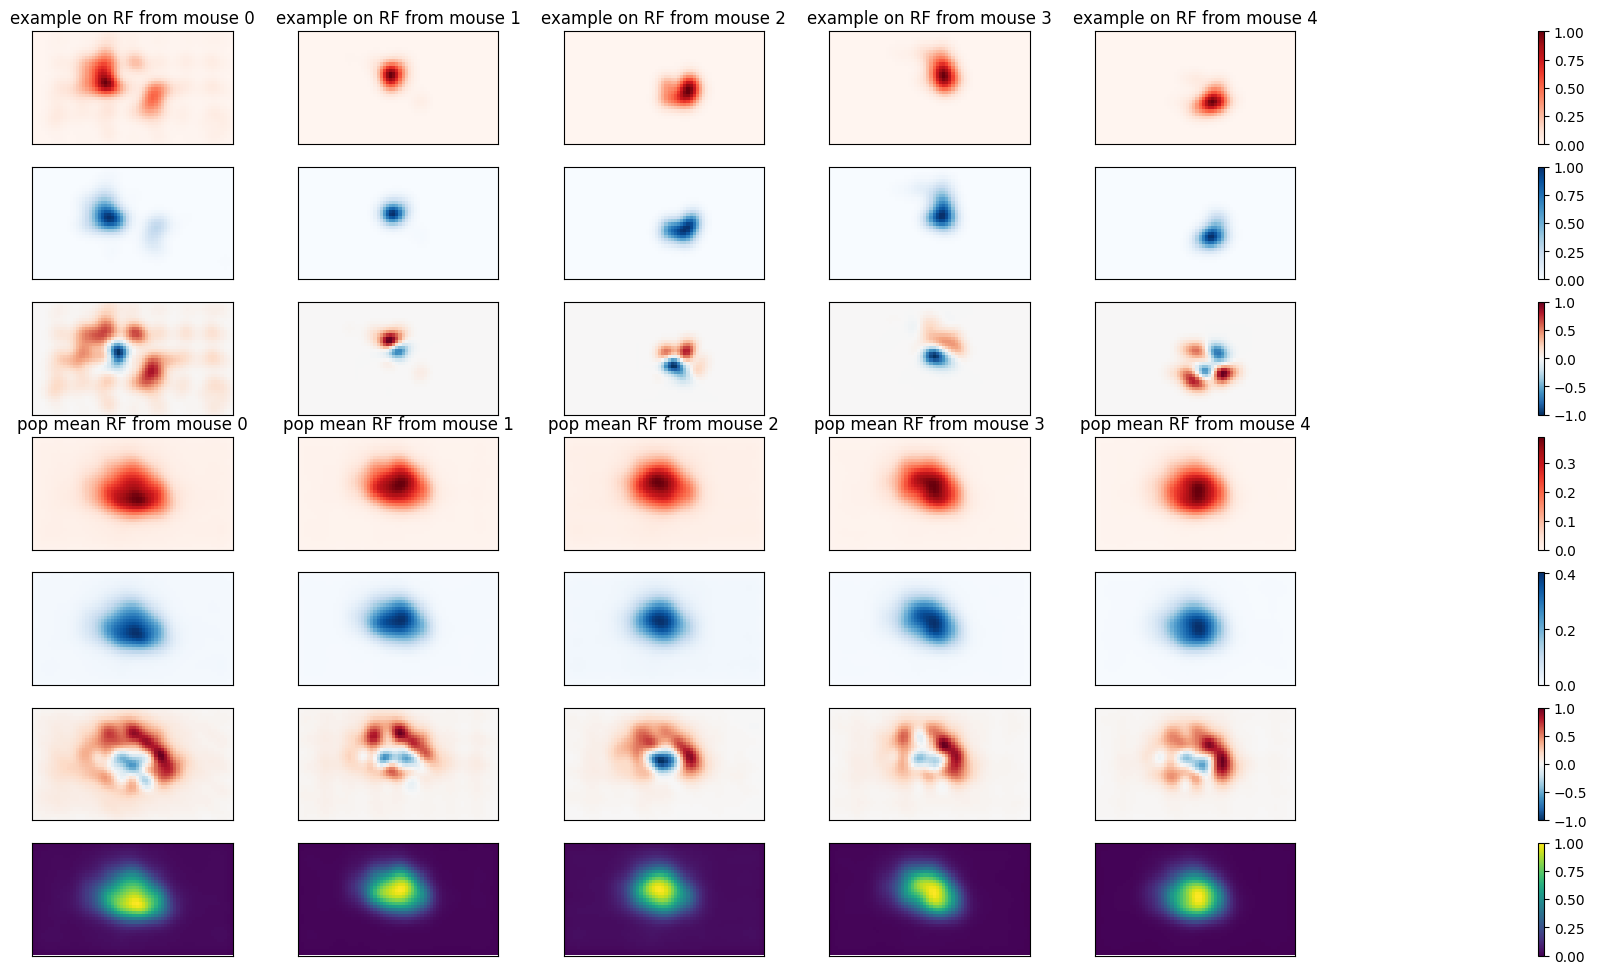

In [14]:
fig, ax = plt.subplots(7, 6, figsize=(20, 12))
for mouse_n in range(len(mice)):
    rand_cell = np.random.randint(0,5000)
    ax[0,mouse_n].imshow(RF_responses_on[mouse_n,:,:,rand_cell],vmin=0,cmap='Reds')
    ax[0,mouse_n].set_title(f'example on RF from mouse {mice[mouse_n]}')
    ax[0,mouse_n].set_xticks([])
    ax[0,mouse_n].set_yticks([])
    ax[1,mouse_n].imshow(RF_responses_off[mouse_n,:,:,rand_cell],vmin=0,cmap='Blues')
    ax[1,mouse_n].set_xticks([])
    ax[1,mouse_n].set_yticks([])
    on_n_off = RF_responses_on[mouse_n,:,:,rand_cell]-RF_responses_off[mouse_n,:,:,rand_cell]
    on_n_off = (on_n_off)/(np.abs(on_n_off).max())
    ax[2,mouse_n].imshow(on_n_off,cmap='RdBu_r',vmin=-1,vmax=1)
    # flip colormap
    
    ax[2,mouse_n].set_xticks([])
    ax[2,mouse_n].set_yticks([])
        

for mouse_n in range(len(mice)):
    rand_cell = np.random.randint(0,5000)
    ax[3,mouse_n].imshow(np.nanmean(RF_responses_on[mouse_n,:,:,:],axis=-1),vmin=0,cmap='Reds')
    ax[3,mouse_n].set_title(f'pop mean RF from mouse {mice[mouse_n]}')
    ax[3,mouse_n].set_xticks([])
    ax[3,mouse_n].set_yticks([])
    ax[4,mouse_n].imshow(np.nanmean(RF_responses_off[mouse_n,:,:,:],axis=-1),vmin=0,cmap='Blues')
    ax[4,mouse_n].set_xticks([])
    ax[4,mouse_n].set_yticks([])
    on_n_off = np.nanmean(RF_responses_on[mouse_n,:,:,:],axis=-1)-np.nanmean(RF_responses_off[mouse_n,:,:,:],axis=-1)
    on_n_off = (on_n_off)/(np.abs(on_n_off).max())
    ax[5,mouse_n].imshow(on_n_off,cmap='RdBu_r',vmin=-1,vmax=1)
    ax[5,mouse_n].set_xticks([])
    ax[5,mouse_n].set_yticks([])
    on_or_off = np.nanmean(RF_responses_on[mouse_n,:,:,:],axis=-1)+np.nanmean(RF_responses_off[mouse_n,:,:,:],axis=-1)
    on_or_off = (on_or_off)/(np.abs(on_or_off).max())
    ax[6,mouse_n].imshow(on_or_off,cmap='viridis',vmin=0,vmax=1)
    ax[6,mouse_n].set_xticks([])
    ax[6,mouse_n].set_yticks([])
        
ax[0,5].set_visible(False)
ax[1,5].set_visible(False)
ax[2,5].set_visible(False)     
ax[3,5].set_visible(False)
ax[4,5].set_visible(False)
ax[5,5].set_visible(False)
ax[6,5].set_visible(False)
cbar1 = plt.colorbar(ax[0,4].images[0], ax=ax[0,5], orientation='vertical')
cbar2 = plt.colorbar(ax[1,4].images[0], ax=ax[1,5], orientation='vertical')
cbar3 = plt.colorbar(ax[2,4].images[0], ax=ax[2,5], orientation='vertical')   
cbar4 = plt.colorbar(ax[3,4].images[0], ax=ax[3,5], orientation='vertical')
cbar5 = plt.colorbar(ax[4,4].images[0], ax=ax[4,5], orientation='vertical')
cbar6 = plt.colorbar(ax[5,4].images[0], ax=ax[5,5], orientation='vertical')    
cbar6 = plt.colorbar(ax[6,4].images[0], ax=ax[6,5], orientation='vertical')    


plt.savefig('../reconstructions/example receptive fields.svg', format='svg', dpi=1200)

In [15]:
# pixel wise correlation map

video_corr_map_notmasked = np.zeros((len(mice),len(trials),36,64))
for mouse in mice:
        for trial in trials:
            for h in range(36):
                for w in range(64):
                    if mask[mouse,h,w] >= 0.5:
                        video_corr_map_notmasked[mouse,trial,h,w] = np.corrcoef(video_gt[mouse,trial,:,h,w],video_recon_trainMask[mouse,trial,:,h,w])[0,1]
                    else:
                        video_corr_map_notmasked[mouse,trial,h,w] = np.nan
video_corr_map_notmasked = np.nanmean(video_corr_map_notmasked,axis=1)
video_corr_map = video_corr_map_notmasked.copy()
# video_corr_map_square_mask = video_corr_map_notmasked.copy()
for mouse in mice:
    video_corr_map[mouse] = np.where(mask[mouse] >= 1,video_corr_map[mouse],np.nan)
    # video_corr_map_square_mask[mouse] = np.where(square_mask[mouse] >= 1,video_corr_map_square_mask[mouse],np.nan)




/ceph/margrie/joelb/video_reconstruction_from_sensorium2023_winner/venv_small/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/ceph/margrie/joelb/video_reconstruction_from_sensorium2023_winner/venv_small/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


/tmp/ipykernel_1597428/3519585160.py:12: RuntimeWarning: Mean of empty slice
  video_corr_map_notmasked = np.nanmean(video_corr_map_notmasked,axis=1)


full screen h/w:  93 124  deg


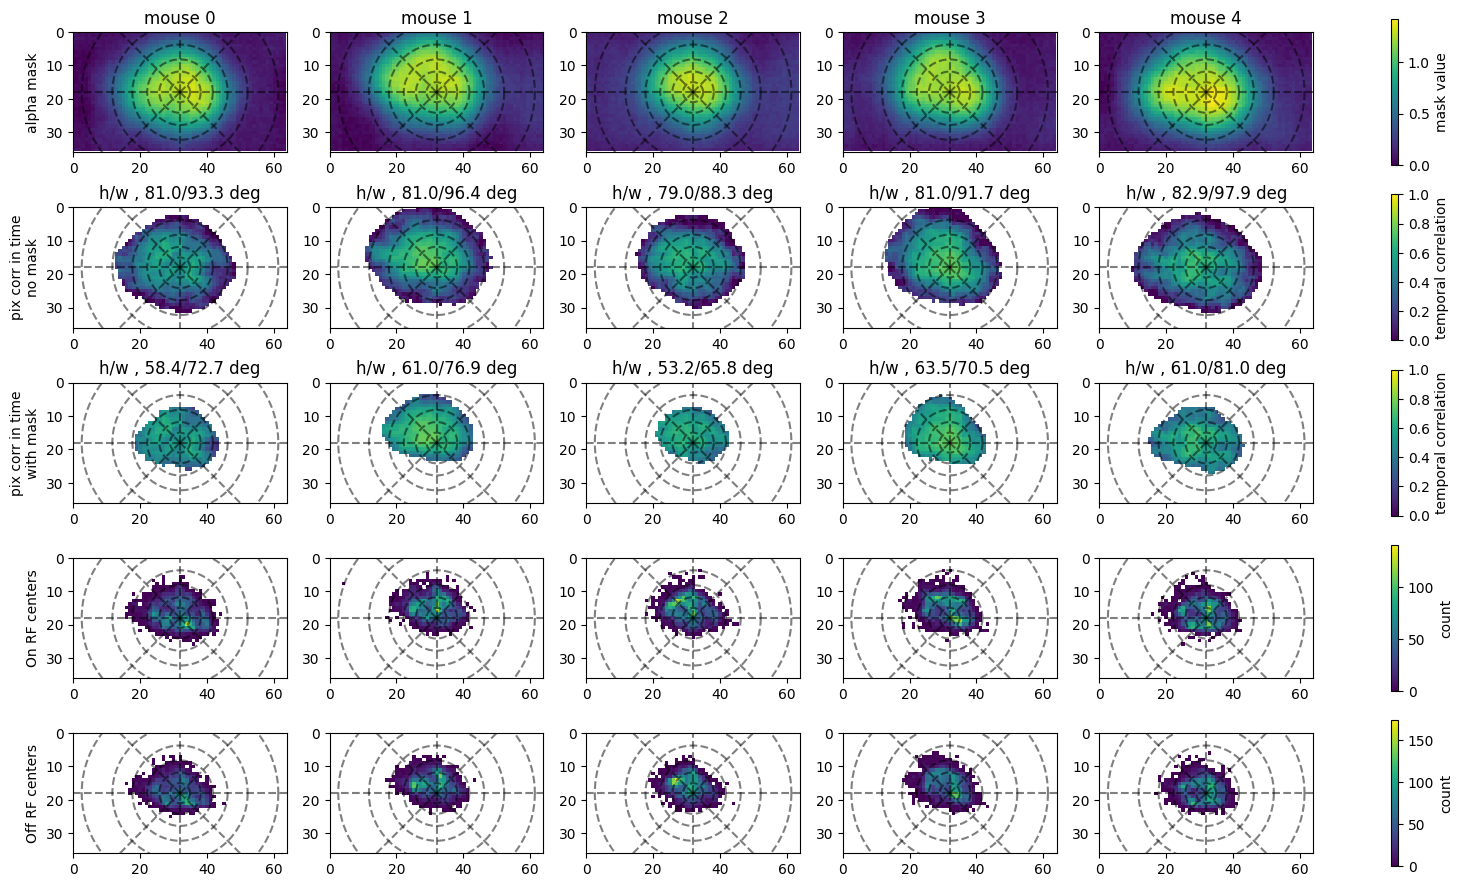

In [17]:
monitor_hight_cm = 31.8
monitor_width_cm = 56.5
monitor_distance_cm = 15
train_mask_width = np.zeros((len(mice)))
train_mask_hight = np.zeros((len(mice)))
eval_mask_width = np.zeros((len(mice)))
eval_mask_hight =np.zeros((len(mice)))
square_mask = np.zeros((len(mice),36,64))

# do draw excentricity circles
radie_deg = range(0,80,10)
radii_pixels = (np.tan(np.deg2rad(radie_deg))* monitor_distance_cm) / (monitor_width_cm / 64)
theta = np.linspace(0, 2*np.pi, 100)

# calculate patch sizes in degrees
train_mask_hight_deg, train_mask_width_deg = calc_mask_size_deg(mask, 0.5,monitor_hight_cm,monitor_width_cm,monitor_distance_cm)
eval_mask_hight_deg, eval_mask_width_deg = calc_mask_size_deg(mask, 1,monitor_hight_cm,monitor_width_cm,monitor_distance_cm)
full_screen_hight_deg, full_screen_width_deg = calc_mask_size_deg(mask, -1,monitor_hight_cm,monitor_width_cm,monitor_distance_cm)


fig, ax = plt.subplots(5, 5, figsize=(20, 11))

for i in range(5):
    ax[0,i].set_title(f'mouse {i}')
    # ax[0,i].imshow(mask[i],cmap='viridis',vmin=0,vmax=np.max(mask))
    ax[0,i].imshow(mask[i],cmap='viridis',vmin=0,vmax=1.5)
    # ax[0,i].axis('off')
    ax[0,0].set_ylabel('alpha mask')
    
    ax[1,i].imshow(video_corr_map_notmasked[i],cmap='viridis',vmin=0,vmax=1)
    ax[1,i].set_title(f'h/w , {train_mask_hight_deg[i]:.1f}/{train_mask_width_deg[i]:.1f} deg')
    # ax[1,i].axis('off')
    ax[1,0].set_ylabel('pix corr in time\nno mask')
    
    ax[2,i].imshow(video_corr_map[i],cmap='viridis',vmin=0,vmax=1)
    ax[2,i].set_title(f'h/w , {eval_mask_hight_deg[i]:.1f}/{eval_mask_width_deg[i]:.1f} deg')
    # ax[2,i].axis('off')
    ax[2,0].set_ylabel('pix corr in time\nwith mask')
    
    # ax[3,i].imshow(video_corr_map_square_mask[i],cmap='viridis',vmin=0,vmax=1)
    # # ax[3,i].axis('off')
    # ax[3,0].set_ylabel('pix corr in time\nwith square mask')
    
    ax[3,i].imshow(ON_RF_map[i],cmap='viridis',vmin=0,vmax=np.nanmax(ON_RF_map))
    ax[3,0].set_ylabel('On RF centers')
    
    ax[4,i].imshow(OFF_RF_map[i],cmap='viridis',vmin=0,vmax=np.nanmax(OFF_RF_map))
    ax[4,0].set_ylabel('Off RF centers')
    
    # draw circles and lines
    for ii in range(5):
        for radius_px in radii_pixels:
            x = 64/2 + radius_px * np.cos(theta)
            y = 36/2 + radius_px * np.sin(theta)
            ax[ii,i].plot(x, y, 'k--', alpha=0.5)
            
        for angle_deg in np.arange(0, 360, 45):
            angle_rad = np.radians(angle_deg)
            x_end = np.cos(angle_rad) * 60  # max angle in plot
            y_end = np.sin(angle_rad) * 60
            ax[ii,i].plot([64/2, 64/2+x_end], [36/2, 36/2+y_end], color='black', linestyle='--', alpha=0.5)
            ax[ii,i].set_xlim(0, 64)
            ax[ii,i].set_ylim(36, 0)  # invert y-axis for image coordinates
    


#add colorbars for all rows
cbar = fig.colorbar(ax[0,i].imshow(mask[-1],cmap='viridis',vmin=0,vmax=np.max(mask)), ax=ax[0,:])
cbar.set_label('mask value')
cbar = fig.colorbar(ax[1,i].imshow(video_corr_map_notmasked[-1],cmap='viridis',vmin=0,vmax=1), ax=ax[1,:])
cbar.set_label('temporal correlation')
cbar = fig.colorbar(ax[2,i].imshow(video_corr_map[-1],cmap='viridis',vmin=0,vmax=1), ax=ax[2,:])
cbar.set_label('temporal correlation')
# cbar = fig.colorbar(ax[3,i].imshow(video_corr_map_square_mask[0],cmap='viridis',vmin=0,vmax=1), ax=ax[3,:])
# cbar.set_label('video correlation')
cbar = fig.colorbar(ax[3,i].imshow(ON_RF_map[-1],cmap='viridis',vmin=0,vmax=np.nanmax(ON_RF_map)), ax=ax[3,:])
cbar.set_label('count')
cbar = fig.colorbar(ax[4,i].imshow(OFF_RF_map[-1],cmap='viridis',vmin=0,vmax=np.nanmax(OFF_RF_map)), ax=ax[4,:])
cbar.set_label('count')
    
print('full screen h/w: ', int(full_screen_hight_deg[0]),int(full_screen_width_deg[0]), ' deg')
plt.savefig('../reconstructions/Mask vs RF.svg', format='svg', dpi=1200)